In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# ============================================================
# CELL 1: IMPORTS AND LOGGING SETUP
# ============================================================
import os
import sys
import json
import csv
import re
import time
import logging
from pathlib import Path
from datetime import datetime
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Project root
ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(ROOT))

# ============================================================
# LOGGING CONFIGURATION
# ============================================================
from src.utils.logging_config import Colors, setup_notebook_logging

# Configuration - CHANGE THESE AS NEEDED
EXPERIMENT_NAME = 'cvl_pipeline'
DEBUG_CONSOLE = False  # Set to True to show DEBUG logs in console
LOG_DIR = ROOT / 'experiments' / 'cvl_pages_v2' / 'logs'

# Setup notebook logging (DEBUG always goes to file, console level configurable)
logger = setup_notebook_logging(
    experiment_name=EXPERIMENT_NAME,
    log_dir=str(LOG_DIR),
    debug=DEBUG_CONSOLE
)


# Print colored header
def print_header(title: str, subtitle: str = None):
    """Print a colored header for the notebook."""
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_GREEN}🚀 {title}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.CYAN}📅 Date:{Colors.RESET} {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    logging.info(f'{Colors.CYAN}📂 Project Root:{Colors.RESET} {ROOT}')
    logging.info(f'{Colors.CYAN}📁 Log Directory:{Colors.RESET} {LOG_DIR}')
    logging.info(f'{Colors.CYAN}📜 Log File:{Colors.RESET} {logger.log_file}')
    logging.info(f'{Colors.CYAN}🔧 Debug Console:{Colors.RESET} {DEBUG_CONSOLE}')
    device_str = "CUDA" if torch.cuda.is_available() else "CPU"
    logging.info(f'{Colors.CYAN}🖥️  Device:{Colors.RESET} {device_str}')
    if torch.cuda.is_available():
        logging.info(f'{Colors.GRAY}   GPU: {torch.cuda.get_device_name(0)}{Colors.RESET}')
        logging.info(
            f'{Colors.GRAY}   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB{Colors.RESET}')
    if subtitle:
        logging.info(f'{Colors.YELLOW}{subtitle}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')


print_header('CVL WRITER RETRIEVAL - COMPLETE PIPELINE')

In [ ]:
# ============================================================
# CELL 2: PROJECT IMPORTS
# ============================================================
logger.info(Colors.BOLD_CYAN + '📦 Loading project modules...' + Colors.RESET)
# Scripts
from scripts.make_cvl_csv import main as make_cvl_csv
from scripts.make_cvl_labels import main as make_cvl_labels
from scripts.make_cvl_text_quantity import main as make_cvl_text_quantity
from scripts.make_ranks import main as make_ranks

# Training - Patch Level
from src.train.train_resnet_triplet import main as train_resnet_triplet
from src.train.fit_vlad_centers import main as fit_vlad_centers
from src.train.patch_dataset import PatchDataset
from src.train.triplet_loss import get_loss_function
from src.train.samplers import MPerClassSampler
from src.train.augmentation import get_train_augmentation

# Training - End-to-End (RECOMMENDED)
from src.train.page_bag_dataset import PageBagDataset, create_page_dataloader
from src.models.e2e_writer_net import EndToEndWriterNet

# Features
from src.features.resnet_patch_extractor import create_resnet_patch_encoder
from src.sampling.adaptive_sampler import AdaptiveSamplingConfig

# Evaluation
from src.evaluation.eval_retrieval import main as eval_retrieval
from src.evaluation.per_bin_csv import main as per_bin_csv
from src.evaluation.metrics import mean_average_precision
from src.evaluation.retrieval_engine import (
    extract_descriptors, fit_pca_whitening, apply_pca_whitening, RetrievalConfig
)

# Reranking
from src.reranking.sgr import apply_sgr

# Utils
from src.utils.preprocessing import load_image, binarize_otsu

logger.info(Colors.GREEN + '✅ All project modules loaded successfully!' + Colors.RESET)

In [ ]:
# ============================================================
# CELL 3: PATH CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '📂 Configuring paths...' + Colors.RESET)
# ============================================================
# 🔧 DATA LEVEL CONFIGURATION - CHANGE THIS TO SWITCH LEVELS
# ============================================================
# Options: 'pages' (full page images), 'lines' (individual text lines), 'words' (individual words)
# - 'pages': Full page images (easiest, most text per sample) - RECOMMENDED
# - 'lines': Individual text lines (medium difficulty)
# - 'words': Individual words (hardest, least text per sample)
DATA_LEVEL = 'pages'  # <-- CHANGE THIS TO 'lines' OR 'words' AS NEEDED

# Level-specific settings
LEVEL_CONFIGS = {
    'pages': {
        'description': 'Full page images',
        'subdir': 'pages',
        'patches_per_call': 8,  # More patches for larger images
        'm_per_class': 4,  # More samples per class
        'max_patches': 1500,
    },
    'lines': {
        'description': 'Individual text lines',
        'subdir': 'lines',
        'patches_per_call': 4,  # Fewer patches for smaller images
        'm_per_class': 8,  # More samples needed per class
        'max_patches': 200,
    },
    'words': {
        'description': 'Individual words (hardest task)',
        'subdir': 'words',
        'patches_per_call': 2,  # Even fewer patches
        'm_per_class': 12,  # Many samples needed
        'max_patches': 50,
    },
}

# Get level config
LEVEL_CFG = LEVEL_CONFIGS[DATA_LEVEL]
logger.info(Colors.CYAN + f'   📊 Data Level: {DATA_LEVEL} ({LEVEL_CFG["description"]})' + Colors.RESET)
# Data paths
DATA_DIR = ROOT / 'data'
CVL_DATA_DIR = DATA_DIR / 'CVL'

# Experiment paths (include level in name for organization)
EXP_DIR = ROOT / 'experiments' / f'cvl_{DATA_LEVEL}_v2'
CHECKPOINT_DIR = EXP_DIR / 'checkpoints'
RESULTS_DIR = EXP_DIR / 'results'

# Create directories
EXP_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# File paths
CVL_TRAIN_CSV = EXP_DIR / 'cvl_train.csv'
CVL_TEST_CSV = EXP_DIR / 'cvl_test.csv'
CVL_LABELS_JSON = EXP_DIR / 'cvl_labels.json'
CVL_TEXT_QTY_JSON = EXP_DIR / 'cvl_text_quantity.json'

logger.info(Colors.CYAN + f'   📊 Data Level: {DATA_LEVEL} ({LEVEL_CFG["description"]})' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Data Dir: {CVL_DATA_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Experiment Dir: {EXP_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Checkpoints Dir: {CHECKPOINT_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   📁 Results Dir: {RESULTS_DIR}' + Colors.RESET)
logger.info(Colors.GREEN + '✅ Paths configured!' + Colors.RESET)

## Step 1: Data Preparation

Generate train/test CSVs from the original CVL split based on the selected `DATA_LEVEL` (pages, lines, or words) and verify writer disjointness.

In [ ]:
# ============================================================
# CELL 4: DATA PREPARATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📁 STEP 1: DATA PREPARATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Convert DATA_LEVEL to script format ('pages' -> 'page', 'lines' -> 'line', 'words' -> 'word')
LEVEL_MAP = {'pages': 'page', 'lines': 'line', 'words': 'word'}
script_level = LEVEL_MAP.get(DATA_LEVEL, 'page')

logger.info(Colors.CYAN + f'   📊 Using data level: {DATA_LEVEL} (script: {script_level})' + Colors.RESET)
# Check if CVL data exists
if not CVL_DATA_DIR.exists():
    logger.error(Colors.RED + f'❌ CVL data not found at: {CVL_DATA_DIR}' + Colors.RESET)
    logger.error(Colors.RED + '   Please download the CVL dataset first.' + Colors.RESET)
else:
    # Count available images for the selected level
    trainset_dir = CVL_DATA_DIR / 'trainset' / DATA_LEVEL
    testset_dir = CVL_DATA_DIR / 'testset' / DATA_LEVEL

    # Count images (handle nested structure for words)
    if DATA_LEVEL == 'words':
        train_images = list(trainset_dir.rglob('*.tif')) if trainset_dir.exists() else []
        test_images = list(testset_dir.rglob('*.tif')) if testset_dir.exists() else []
    else:
        train_images = list(trainset_dir.glob('*.tif')) if trainset_dir.exists() else []
        test_images = list(testset_dir.glob('*.tif')) if testset_dir.exists() else []

    logger.info(Colors.CYAN + f'   📊 CVL Dataset Overview ({DATA_LEVEL}):' + Colors.RESET)
    logger.info(Colors.CYAN + f'      📂 Trainset: {len(train_images)} {DATA_LEVEL}' + Colors.RESET)
    logger.info(Colors.CYAN + f'      📂 Testset: {len(test_images)} {DATA_LEVEL}' + Colors.RESET)

    # Generate CSVs with the correct level
    logger.info(Colors.MAGENTA + '\n🔄 Generating train/test CSVs for level=' + script_level + '...' + Colors.RESET)
    make_cvl_csv(data_dir=CVL_DATA_DIR, out_train=CVL_TRAIN_CSV, out_test=CVL_TEST_CSV, level=script_level)

    # Generate labels JSON
    logger.info(Colors.MAGENTA + '\n🔄 Generating labels JSON...' + Colors.RESET)
    make_cvl_labels(csv_path=CVL_TEST_CSV, out_json=CVL_LABELS_JSON)

    # Compute text quantity
    logger.info(Colors.MAGENTA + '\n🔄 Computing text quantity...' + Colors.RESET)
    make_cvl_text_quantity(csv_path=CVL_TEST_CSV, out_json=CVL_TEXT_QTY_JSON)

    logger.info(Colors.GREEN + '✅ Data preparation complete!' + Colors.RESET)

In [7]:
# ============================================================
# CELL 5: VERIFY WRITER DISJOINT SPLIT
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n🔍 STEP 1.5: VERIFY WRITER-DISJOINT SPLIT' + Colors.RESET)


# Load train/test writer IDs
def load_writers_from_csv(csv_path):
    writers = set()
    pages = 0
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            writers.add(int(row['writer_id']))
            pages += 1
    return writers, pages


train_writers, n_train = load_writers_from_csv(CVL_TRAIN_CSV)
test_writers, n_test = load_writers_from_csv(CVL_TEST_CSV)
overlap = train_writers & test_writers

logger.info(Colors.CYAN + f'\n📊 Split Statistics:' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╔══════════════════════════════════════════╗' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ║  Split   │  Writers  │  Pages  │ Avg     ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╠══════════════════════════════════════════╣' + Colors.RESET)
logger.info(
    Colors.YELLOW + f'   ║  Train   │  {len(train_writers):6d}   │  {n_train:5d}  │ {n_train / len(train_writers):4.1f}    ║' + Colors.RESET)
logger.info(
    Colors.YELLOW + f'   ║  Test    │  {len(test_writers):6d}   │  {n_test:5d}  │ {n_test / len(test_writers):4.1f}    ║' + Colors.RESET)
logger.info(Colors.YELLOW + f'   ╚══════════════════════════════════════════╝' + Colors.RESET)

logger.info(Colors.CYAN + f'\n🔍 Writer Overlap: {len(overlap)}' + Colors.RESET)
if len(overlap) == 0:
    logger.info(Colors.GREEN + '   ✅ PERFECT! No overlapping writers - correct evaluation protocol!' + Colors.RESET)
else:
    logger.error(Colors.RED + f'   ❌ WARNING: {len(overlap)} overlapping writers detected!' + Colors.RESET)
    logger.error(Colors.RED + f'   Overlapping IDs: {sorted(overlap)[:10]}...' + Colors.RESET)

22:32:54 | INFO     | ℹ️  
🔍 STEP 1.5: VERIFY WRITER-DISJOINT SPLIT
22:32:54 | INFO     | ℹ️  
📊 Split Statistics:
22:32:54 | INFO     | ℹ️     ╔══════════════════════════════════════════╗
22:32:54 | INFO     | ℹ️     ║  Split   │  Writers  │  Pages  │ Avg     ║
22:32:54 | INFO     | ℹ️     ╠══════════════════════════════════════════╣
22:32:54 | INFO     | ℹ️     ║  Train   │      27   │    189  │  7.0    ║
22:32:54 | INFO     | ℹ️     ║  Test    │     283   │   1415  │  5.0    ║
22:32:54 | INFO     | ℹ️     ╚══════════════════════════════════════════╝
22:32:54 | INFO     | ℹ️  
🔍 Writer Overlap: 0
22:32:54 | INFO     | ℹ️     ✅ PERFECT! No overlapping writers - correct evaluation protocol!


## Step 2: Exploratory Data Analysis

Visualize dataset statistics and text quantity distribution.

In [ ]:
# ============================================================
# CELL 6: EXPLORATORY DATA ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 2: EXPLORATORY DATA ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Load text quantity
with open(CVL_TEXT_QTY_JSON, 'r') as f:
    text_qty = json.load(f)

line_counts = list(text_qty.values())

# Statistics
logger.info(Colors.CYAN + f'\n📈 Text Quantity Statistics:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Total pages: {len(line_counts)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Mean lines: {np.mean(line_counts):.1f}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Median lines: {np.median(line_counts):.1f}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Min lines: {min(line_counts)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Max lines: {max(line_counts)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Std dev: {np.std(line_counts):.1f}' + Colors.RESET)

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(line_counts, bins=range(0, max(line_counts) + 2),
             color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(np.mean(line_counts), color='red', linestyle='--',
                label=f'Mean: {np.mean(line_counts):.1f}')
axes[0].axvline(np.median(line_counts), color='orange', linestyle='--',
                label=f'Median: {np.median(line_counts):.1f}')
axes[0].set_xlabel('Line Count')
axes[0].set_ylabel('Number of Pages')
axes[0].set_title('Distribution of Line Counts')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Pages per writer (test set)
writer_page_counts = defaultdict(int)
with open(CVL_TEST_CSV, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        writer_page_counts[row['writer_id']] += 1

pages_per_writer = list(writer_page_counts.values())
axes[1].hist(pages_per_writer, bins=range(1, max(pages_per_writer) + 2),
             color='forestgreen', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Pages per Writer')
axes[1].set_ylabel('Number of Writers')
axes[1].set_title('Pages per Writer (Test Set)')
axes[1].grid(axis='y', alpha=0.3)

# Box plot by quantile bins
bins = ['1-3 lines', '4-6 lines', '7-10 lines', '11+ lines']
bin_data = [
    [lc for lc in line_counts if lc <= 3],
    [lc for lc in line_counts if 4 <= lc <= 6],
    [lc for lc in line_counts if 7 <= lc <= 10],
    [lc for lc in line_counts if lc >= 11]
]
bin_counts = [len(b) for b in bin_data]

axes[2].bar(bins, bin_counts, color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'],
            edgecolor='white')
axes[2].set_xlabel('Line Count Bin')
axes[2].set_ylabel('Number of Pages')
axes[2].set_title('Pages by Text Quantity Bin')
for i, v in enumerate(bin_counts):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

logger.info(Colors.GREEN + '✅ EDA complete!' + Colors.RESET)

## Step 3: Training Configuration

Define training hyperparameters and experiment configurations.

In [ ]:
# ============================================================
# CELL 7: TRAINING CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n⚙️  STEP 3: TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
# ===== CVL-OPTIMIZED CONFIGURATION =====
# Settings are adjusted based on DATA_LEVEL (pages, lines, or words)

logger.info(Colors.CYAN + f'\n📊 Data Level: {DATA_LEVEL} ({LEVEL_CFG["description"]})' + Colors.RESET)
logger.info(Colors.CYAN + f'   Using level-specific settings from LEVEL_CFG' + Colors.RESET)

CVL_CONFIG = {
    # Data Level
    'data_level': DATA_LEVEL,  # Current data level

    # Model
    'backbone': 'resnet18',  # Options: 'small', 'small_deep', 'resnet18', 'resnet34'
    'pretrained': True,  # Use ImageNet pretrained weights
    'emb_dim': 128,  # Embedding dimension
    'freeze_bn': False,  # Freeze batch norm layers

    # Training
    'epochs': 30,  # More epochs for thorough training
    'batch_size': 128,  # Batch size
    'lr': 1e-4,  # Initial learning rate
    'final_lr': 1e-6,  # Final learning rate (cosine schedule)
    'warmup_epochs': 5,  # Warmup epochs
    'weight_decay': 0,  # Weight decay (0 for metric learning)
    'grad_clip': 2.0,  # Gradient clipping
    'patience': 7,  # Early stopping patience

    # Loss
    'loss_type': 'triplet',  # Options: 'triplet', 'semi_hard', 'ms', 'circle'
    'margin': 0.35,  # Triplet margin (higher for CVL)

    # Sampling - Use level-specific settings
    'm_per_class': LEVEL_CFG['m_per_class'],  # Samples per class (level-dependent)
    'patches_per_call': LEVEL_CFG['patches_per_call'],  # Multi-patch training (level-dependent)
    'sampler_mode': 'contour',  # Options: 'dense', 'char', 'adaptive'
    'patch_size': 32,  # Patch size
    'max_patches': LEVEL_CFG['max_patches'],  # Max patches per image (level-dependent)

    # Augmentation
    'augment': True,
    'strong_augment': False,

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4,
}

# Log configuration
logger.info(Colors.MAGENTA + '\n📋 CVL Training Configuration:' + Colors.RESET)
logger.info(Colors.YELLOW + '   ┌─────────────────────────────────────────────┐' + Colors.RESET)
for key, value in CVL_CONFIG.items():
    logger.info(Colors.YELLOW + f'   │ {key:20s} │ {str(value):20s} │' + Colors.RESET)
logger.info(Colors.YELLOW + '   └─────────────────────────────────────────────┘' + Colors.RESET)

# Calculate expected training stats
n_train_images = n_train
patches_per_epoch = n_train_images * CVL_CONFIG['patches_per_call']
batches_per_epoch = patches_per_epoch // CVL_CONFIG['batch_size']

logger.info(Colors.CYAN + f'\n📊 Training Statistics:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Data level: {DATA_LEVEL}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train images: {n_train_images}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Patches per image: {CVL_CONFIG["patches_per_call"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Max patches per image: {CVL_CONFIG["max_patches"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Patches per epoch: {patches_per_epoch:,}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Batches per epoch: ~{batches_per_epoch}' + Colors.RESET)

## Step 3.5: End-to-End Training Configuration (RECOMMENDED)

**Why End-to-End Training is Better:**

The standard patch-level training (Step 4) computes loss on **individual patches**. This is suboptimal because:
- Patches from the same writer can look very different (letter "a" vs word "the")
- The model learns patch similarity, not writer similarity
- This limits mAP to ~38% in practice

**End-to-End Training** computes loss on **aggregated PAGE descriptors**:
- All patches from a page are encoded and pooled (e.g., GeM pooling)
- Loss is computed on the pooled descriptor
- The model learns that "Page A and Page B come from the same writer"
- This can achieve 90%+ mAP

**Choose ONE training approach:**
- **Option A (below)**: End-to-End Training (RECOMMENDED for best results)
- **Option B (Step 4)**: Patch-Level Training (faster, for comparison/pretraining)

In [ ]:
# ============================================================
# CELL 7.5: END-TO-END TRAINING CONFIGURATION
# ============================================================
# Set this to True to use E2E training (RECOMMENDED)
# Set to False to skip and use patch-level training (Step 4)
!rm -rf experiments/cvl_pages_v2/checkpoints/*
USE_E2E_TRAINING = True

E2E_CONFIG = {
    **CVL_CONFIG,
    # Aggregation - GeM works best for most cases
    'agg_type': 'gem',  # Options: 'gem', 'mean', 'netvlad', 'netrvlad'
    'gem_p': 3.0,  # Initial GeM power (learnable)
    'num_clusters': 100,  # For NetVLAD only

    # Page-level training
    'patches_per_page': 32,  # Patches per page (32-64 recommended)
    'batch_size': 16,  # Pages per batch (limited by GPU memory)
    'm_per_class': 2,  # Pages per writer per batch (2 is standard)

    # Training
    'epochs': 50,  # More epochs for E2E
    'lr': 1e-4,  # Learning rate
    'final_lr': 1e-6,  # Final LR for cosine schedule
    'warmup_epochs': 5,
    'margin': 0.1,  # Triplet margin
    'weight_decay': 1e-5,
    'patience': 15,  # Early stopping patience

    # Use pretrained patch encoder (optional)
    'pretrained': None,  # Set to checkpoint path to fine-tune
}

logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n⚙️  END-TO-END TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if USE_E2E_TRAINING:
    logger.info(Colors.GREEN + '\n✅ E2E Training ENABLED (recommended for best mAP)' + Colors.RESET)
    logger.info(Colors.MAGENTA + '\n📋 E2E Configuration:' + Colors.RESET)
    logger.info(Colors.YELLOW + '   ┌─────────────────────────────────────────────┐' + Colors.RESET)
    for key, value in E2E_CONFIG.items():
        logger.info(Colors.YELLOW + f'   │ {key:20s} │ {str(value):20s} │' + Colors.RESET)
    logger.info(Colors.YELLOW + '   └─────────────────────────────────────────────┘' + Colors.RESET)
    # Memory estimate
    mem_per_page = E2E_CONFIG['patches_per_page'] * 32 * 32 * 4  # float32
    mem_per_batch = E2E_CONFIG['batch_size'] * mem_per_page / 1e6
    logger.info(Colors.CYAN + f'\n📊 Memory Estimate:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ~{mem_per_batch:.1f} MB per batch (input only)' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Actual usage depends on model size and gradients' + Colors.RESET)
else:
    logger.info(Colors.YELLOW + '\n⚠️  E2E Training DISABLED - will use patch-level training (Step 4)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   To enable, set USE_E2E_TRAINING = True above' + Colors.RESET)

In [ ]:
# ============================================================
# CELL 7.6: RUN END-TO-END TRAINING
# ============================================================
if USE_E2E_TRAINING:
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '\n🏋️  END-TO-END TRAINING' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

    # Import E2E training
    from src.train.train_e2e import main as train_e2e

    # Build training arguments
    e2e_args = [
        '--csv', str(CVL_TRAIN_CSV),
        '--root-dir', str(ROOT),
        '--epochs', str(E2E_CONFIG['epochs']),
        '--batch-size', str(E2E_CONFIG['batch_size']),
        '--patches-per-page', str(E2E_CONFIG['patches_per_page']),
        '--agg-type', E2E_CONFIG['agg_type'],
        '--gem-p', str(E2E_CONFIG['gem_p']),
        '--lr', str(E2E_CONFIG['lr']),
        '--final-lr', str(E2E_CONFIG['final_lr']),
        '--warmup-epochs', str(E2E_CONFIG['warmup_epochs']),
        '--margin', str(E2E_CONFIG['margin']),
        '--m-per-class', str(E2E_CONFIG['m_per_class']),
        '--weight-decay', str(E2E_CONFIG['weight_decay']),
        '--emb-dim', str(CVL_CONFIG['emb_dim']),
        '--sampler', CVL_CONFIG['sampler_mode'],
        '--device', CVL_CONFIG['device'],
        '--patience', str(CVL_CONFIG['patience']),
        '--save-dir', str(CHECKPOINT_DIR),
        '--debug',
        '--cache-patches',
    ]

    if E2E_CONFIG['pretrained']:
        e2e_args.extend(['--pretrained', str(E2E_CONFIG['pretrained'])])

    if CVL_CONFIG['augment']:
        e2e_args.append('--augment')

    logger.info(Colors.MAGENTA + '\n📋 E2E Training Arguments:' + Colors.RESET)
    for i in range(0, len(e2e_args), 2):
        if i + 1 < len(e2e_args) and not e2e_args[i + 1].startswith('--'):
            logger.info(Colors.YELLOW + f'   {e2e_args[i]}: {e2e_args[i + 1]}' + Colors.RESET)

    logger.info(Colors.CYAN + '\n🚀 Starting End-to-End training...' + Colors.RESET)
    logger.info(Colors.CYAN + '   📍 KEY DIFFERENCE: Loss on PAGE descriptors, not patches!' + Colors.RESET)
    logger.info(Colors.CYAN + '   This learns WRITER similarity, not patch similarity.' + Colors.RESET)
    logger.info(Colors.CYAN + '' + Colors.RESET)

    # Run training
    sys.argv = ['train_e2e.py'] + e2e_args
    train_start = time.time()

    try:
        train_e2e()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ E2E Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)
        logger.info(
            Colors.GREEN + '   📁 Saved: best_*.pt (full E2E model), encoder_*.pt (patch encoder only)' + Colors.RESET)
    except Exception as e:
        logger.error(Colors.RED + f'❌ E2E Training failed: {e}' + Colors.RESET)
        raise
else:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping E2E training (USE_E2E_TRAINING = False)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   Will use patch-level training in Step 4 instead.' + Colors.RESET)

## Step 4: Train Patch Encoder

Train the ResNet patch encoder with improved training pipeline.

In [ ]:
# ============================================================
# CELL 8: TRAIN PATCH ENCODER (ALTERNATIVE TO E2E)
# ============================================================
# Skip this cell if you used E2E training above
if USE_E2E_TRAINING:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping patch-level training (E2E training was used)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   The E2E model already includes the patch encoder.' + Colors.RESET)
else:
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '\n🏋️  STEP 4: TRAIN PATCH ENCODER (Patch-Level)' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
    logger.info(Colors.YELLOW + '\n⚠️  NOTE: This is patch-level training (suboptimal)' + Colors.RESET)
    logger.info(Colors.YELLOW + '   Consider using E2E training (Step 3.5) for better mAP.' + Colors.RESET)
    # Build training arguments
    train_args = [
        '--csv', str(CVL_TRAIN_CSV),
        '--root-dir', str(ROOT),
        '--epochs', str(CVL_CONFIG['epochs']),
        '--batch-size', str(CVL_CONFIG['batch_size']),
        '--sampler', CVL_CONFIG['sampler_mode'],
        '--emb-dim', str(CVL_CONFIG['emb_dim']),
        '--warmup-epochs', str(CVL_CONFIG['warmup_epochs']),
        '--grad-clip', str(CVL_CONFIG['grad_clip']),
        '--m-per-class', str(CVL_CONFIG['m_per_class']),
        '--device', CVL_CONFIG['device'],
        '--patience', str(CVL_CONFIG['patience']),
        '--save-dir', str(CHECKPOINT_DIR),
        '--debug',
    ]

    if CVL_CONFIG['augment']:
        train_args.append('--augment')

    logger.info(Colors.MAGENTA + '\n📋 Training Arguments:' + Colors.RESET)
    for i in range(0, len(train_args), 2):
        if i + 1 < len(train_args) and not train_args[i + 1].startswith('--'):
            logger.info(Colors.YELLOW + f'   {train_args[i]}: {train_args[i + 1]}' + Colors.RESET)

    logger.info(Colors.CYAN + '\n🚀 Starting patch-level training...' + Colors.RESET)
    logger.info(Colors.CYAN + '   📍 NOTE: Loss is computed on PATCH descriptors, not pages.' + Colors.RESET)
    logger.info(Colors.CYAN + '   This learns PATCH similarity, not writer similarity.' + Colors.RESET)
    logger.info(Colors.CYAN + '' + Colors.RESET)

    # Run training
    sys.argv = ['train_resnet_triplet.py'] + train_args
    train_start = time.time()

    try:
        train_resnet_triplet()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)
        logger.info(Colors.GREEN + '   📁 Saved: best_epoch_*.pt' + Colors.RESET)
    except Exception as e:
        logger.error(Colors.RED + f'❌ Training failed: {e}' + Colors.RESET)
        raise

In [5]:
# ============================================================
# CELL 9: FIND BEST CHECKPOINT
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔍 STEP 4.5: FIND BEST CHECKPOINT' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
# Find all checkpoints - both E2E and patch-level formats
# E2E checkpoints have encoder_*.pt (just the patch encoder)
# Patch-level checkpoints have best_epoch_*.pt

ckpt_list = list(CHECKPOINT_DIR.glob('best_epoch*_loss*.pt'))
encoder_list = list(CHECKPOINT_DIR.glob('encoder_epoch*_loss*.pt'))

if not ckpt_list and not encoder_list:
    # Try notebooks checkpoints as fallback
    ckpt_list = list((ROOT / 'notebooks' / 'checkpoints').glob('best_epoch*_loss*.pt'))


def extract_loss(p):
    m = re.search(r'loss_([0-9.]+)\.pt$', p.name)
    return float(m.group(1)) if m else float('inf')


# For E2E training, prefer encoder_*.pt (patch encoder only, compatible with eval)
# For patch-level, use best_epoch_*.pt
if encoder_list:
    logger.info(Colors.CYAN + '   📍 Found E2E encoder checkpoints (recommended)' + Colors.RESET)
    ckpt_list_sorted = sorted(encoder_list, key=extract_loss)
    is_e2e = True
elif ckpt_list:
    logger.info(Colors.CYAN + '   📍 Found patch-level checkpoints' + Colors.RESET)
    ckpt_list_sorted = sorted(ckpt_list, key=extract_loss)
    is_e2e = False
else:
    ckpt_list_sorted = []
    is_e2e = False

if ckpt_list_sorted:
    best_ckpt = ckpt_list_sorted[0]

    logger.info(Colors.CYAN + f'\n📂 Found {len(ckpt_list_sorted)} checkpoints:' + Colors.RESET)
    for i, ckpt in enumerate(ckpt_list_sorted[:5]):
        marker = ' ⭐ BEST' if i == 0 else ''
        logger.info(Colors.YELLOW + f'   {i + 1}. {ckpt.name} (loss: {extract_loss(ckpt):.4f}){marker}' + Colors.RESET)

    if len(ckpt_list_sorted) > 5:
        logger.info(Colors.YELLOW + f'   ... and {len(ckpt_list_sorted) - 5} more' + Colors.RESET)

    # Load and inspect best checkpoint
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    logger.info(Colors.MAGENTA + f'\n📊 Best Checkpoint Details:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Path: {best_ckpt}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Type: {"E2E Encoder" if is_e2e else "Patch-Level"}' + Colors.RESET)

    if isinstance(ckpt_data, dict):
        logger.info(Colors.CYAN + f'   Epoch: {ckpt_data.get("epoch", "N/A")}' + Colors.RESET)
        logger.info(Colors.CYAN + f'   Val Loss: {ckpt_data.get("val_loss", "N/A")}' + Colors.RESET)
        if 'args' in ckpt_data:
            logger.info(Colors.CYAN + f'   Embedding dim: {ckpt_data["args"].get("emb_dim", 64)}' + Colors.RESET)
            logger.info(Colors.CYAN + f'   Aggregation: {ckpt_data["args"].get("agg_type", "N/A")}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoints found!' + Colors.RESET)
    best_ckpt = None

22:32:34 | INFO     | ℹ️  ======================================================================
22:32:34 | INFO     | ℹ️  
🔍 STEP 4.5: FIND BEST CHECKPOINT
22:32:34 | INFO     | ℹ️  ======================================================================
22:32:34 | INFO     | ℹ️     📍 Found E2E encoder checkpoints (recommended)
22:32:34 | INFO     | ℹ️  
📂 Found 1 checkpoints:
22:32:34 | INFO     | ℹ️     1. encoder_epoch_13_loss_0.0947.pt (loss: 0.0947) ⭐ BEST
22:32:34 | INFO     | ℹ️  
📊 Best Checkpoint Details:
22:32:34 | INFO     | ℹ️     Path: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/cvl_pages_v2/checkpoints/encoder_epoch_13_loss_0.0947.pt
22:32:34 | INFO     | ℹ️     Type: E2E Encoder
22:32:34 | INFO     | ℹ️     Epoch: 13
22:32:34 | INFO     | ℹ️     Val Loss: 0.0946974257628123
22:32:34 | INFO     | ℹ️     Embedding dim: 128
22:32:34 | INFO     | ℹ️     Aggregation: N/A


## Step 5: Baseline Evaluation

Evaluate the trained model with default settings.

In [9]:
# ============================================================
# CELL 10: BASELINE EVALUATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 5: BASELINE EVALUATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    logger.info(Colors.CYAN + f'\n🔍 Using checkpoint: {best_ckpt.name}' + Colors.RESET)
    logger.info(
        Colors.CYAN + f'   Evaluating on {n_test} test pages from {len(test_writers)} unseen writers' + Colors.RESET)

    # Basic evaluation with default settings
    eval_args = [
        '--csv', str(CVL_TEST_CSV),
        '--root-dir', str(ROOT),
        '--checkpoint', str(best_ckpt),
        '--agg-type', 'gem',
        '--mode', 'contour',
        '--device', 'cuda' if torch.cuda.is_available() else 'cpu',
    ]

    sys.argv = ['eval_retrieval.py'] + eval_args
    labels, paths, descs, metrics = eval_retrieval()

    # Save descriptors
    descs_path = RESULTS_DIR / 'cvl_descs_baseline.npy'
    np.save(descs_path, descs)

    logger.info(Colors.MAGENTA + f'\n📊 BASELINE RESULTS:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌───────────────────────────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Metric  │  Value                │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠───────────────────────────────┨' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  mAP     │  {metrics["mAP"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Top-1   │  {metrics["Top1"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Top-5   │  {metrics["Top5"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  Top-10  │  {metrics["Top10"] * 100:6.2f}%              │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └───────────────────────────────┘' + Colors.RESET)

    baseline_mAP = metrics['mAP']
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

22:33:58 | INFO     | ℹ️  ======================================================================
22:33:58 | INFO     | ℹ️  
📊 STEP 5: BASELINE EVALUATION
22:33:58 | INFO     | ℹ️  ======================================================================
22:33:58 | INFO     | ℹ️  
🔍 Using checkpoint: encoder_epoch_13_loss_0.0947.pt
22:33:58 | INFO     | ℹ️     Evaluating on 1415 test pages from 283 unseen writers
22:33:58 | INFO     | ℹ️     Backbone from checkpoint: resnet34
22:33:59 | INFO     | ℹ️  ============================================================
22:33:59 | INFO     | 🎯 Writer Retrieval Evaluation
22:33:59 | INFO     | ℹ️  ============================================================
22:33:59 | INFO     | ℹ️  📄 Extracting descriptors from 1415 pages...
22:33:59 | INFO     | ℹ️     Aggregation: gem
22:33:59 | INFO     | ℹ️     GeM p-parameter: 3.0
22:33:59 | INFO     | ℹ️     Power normalization: ON (α=0.4)
22:33:59 | INFO     | ℹ️     PCA whitening: ON
22:33:59 | INFO     | ℹ

Extracting: 100%|██████████| 1415/1415 [02:36<00:00,  9.05it/s]

22:36:35 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 156.3s
22:36:35 | INFO     | ℹ️     Average patches per page: 1270.6
22:36:35 | INFO     | ℹ️     Descriptor dimension: 128
22:36:35 | INFO     | ℹ️     Unique writers: 283
22:36:35 | INFO     | ℹ️  
22:36:35 | INFO     | 📊 Computing retrieval metrics...
22:36:35 | INFO     | 📊 Computing retrieval metrics...
22:36:35 | INFO     | ℹ️     Queries: 1415
22:36:35 | INFO     | ℹ️     Descriptor dim: 128
22:36:35 | INFO     | ℹ️     Unique writers: 283
22:36:35 | INFO     | ℹ️     Computing similarity matrix...


22:36:35 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:36:35 | INFO     | ℹ️  
22:36:35 | INFO     | ℹ️     ╔════════════════════════════════╗
22:36:35 | INFO     | ℹ️     ║  mAP:     59.67%              ║
22:36:35 | INFO     | ℹ️     ║  Top-1:   74.42%              ║
22:36:35 | INFO     | ℹ️     ║  Top-5:   91.31%              ║
22:36:35 | INFO     | ℹ️     ║  Top-10:  94.77%              ║
22:36:35 | INFO     | ℹ️     ╚════════════════════════════════╝
22:36:35 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:36:35 | INFO     | ℹ️  
22:36:35 | INFO     | 📈 Results:
22:36:35 | INFO     | ℹ️     mAP:    59.67%
22:36:35 | INFO     | ℹ️  ============================================================
22:36:35 | INFO     | ℹ️  
22:36:35 | INFO     | ℹ️  === Baseline retrieval ===
22:36:35 | INFO     | ℹ️    #queries: 1415
22:36:35 | INFO     | ℹ️    mAP:   0.5967
22:36:35 | INFO     | ℹ️    Top-1: 0.7442
22:36:35 | INFO     | ℹ️    Top-5: 0.9131
22:36:35 | INFO     | ℹ️    Top-10:0.9477

## Step 6: Comprehensive Ablation Study

Test all combinations of:
- **Sampling modes**: dense, contour, adaptive (auto)
- **Aggregation types**: sum, mean, gem, power-normalized
- **Reranking**: none, sgr, sgr_plus

In [11]:
# ============================================================
# CELL 11: COMPREHENSIVE ABLATION STUDY
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔬 STEP 6: COMPREHENSIVE ABLATION STUDY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Define all experiment combinations
MODES = ['auto', 'dense', 'char', 'contour']
AGG_TYPES = ['netrvlad', 'gem', 'mean', 'sum']
RERANKS = ['sgr_plus']  # Reranking is worse so keeping just sgr_plus for speed

# Generate all combinations
experiments = []
for mode in MODES:
    for agg in AGG_TYPES:
        for rerank in RERANKS:
            experiments.append((mode, agg, rerank))

logger.info(Colors.CYAN + f'\n📋 Running {len(experiments)} experiments:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Modes: {MODES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Aggregations: {AGG_TYPES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Reranking: {RERANKS}' + Colors.RESET)

results = []

if best_ckpt:
    for i, (mode, agg, rerank) in enumerate(experiments, 1):
        exp_name = f'{mode}+{agg}+{rerank}'
        logger.info(Colors.MAGENTA + f'\n[{i:2d}/{len(experiments)}] Experiment: {exp_name}' + Colors.RESET)
        # Log table format of configuration
        logger.info(Colors.YELLOW + f'   ┌───────────────────────────────┐' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Parameter  │  Value                │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   ┠───────────────────────────────┨' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Mode       │  {mode:20s} │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Agg Type  │  {agg:20s} │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   │  Rerank     │  {rerank:20s} │' + Colors.RESET)
        logger.info(Colors.YELLOW + f'   └───────────────────────────────┘' + Colors.RESET)

        # Run evaluation
        try:
            args_eval = [
                '--csv', str(CVL_TEST_CSV),
                '--root-dir', str(ROOT),
                '--checkpoint', str(best_ckpt),
                '--agg-type', agg,
                '--mode', mode,
                '--device', 'cuda' if torch.cuda.is_available() else 'cpu',
            ]
            if rerank != 'none':
                args_eval += ['--rerank', rerank]

            sys.argv = ['eval_retrieval.py'] + args_eval
            _, _, _, metrics_dict = eval_retrieval()

            results.append({
                'mode': mode,
                'agg': agg,
                'rerank': rerank,
                'mAP': metrics_dict['mAP'],
                'Top1': metrics_dict['Top1'],
                'Top5': metrics_dict['Top5'],
                'Top10': metrics_dict['Top10'],
            })

            # Log the table format
            logger.info(Colors.YELLOW + f'   ┌───────────────────────────────┐' + Colors.RESET)
            logger.info(Colors.YELLOW + f'   │  Metric  │  Value                │' + Colors.RESET)
            logger.info(Colors.YELLOW + f'   ┠───────────────────────────────┨' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  mAP     │  {metrics_dict["mAP"] * 100:6.2f}%              │' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  Top-1   │  {metrics_dict["Top1"] * 100:6.2f}%              │' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  Top-5   │  {metrics_dict["Top5"] * 100:6.2f}%              │' + Colors.RESET)
            logger.info(
                Colors.YELLOW + f'   │  Top-10  │  {metrics_dict["Top10"] * 100:6.2f}%              │' + Colors.RESET)
            logger.info(Colors.YELLOW + f'   └───────────────────────────────┘' + Colors.RESET)
        except Exception as e:
            logger.error(Colors.RED + f'❌ FAILED: {e}' + Colors.RESET)
            results.append({
                'mode': mode, 'agg': agg, 'rerank': rerank,
                'mAP': 0, 'Top1': 0, 'Top5': 0, 'Top10': 0
            })

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('mAP', ascending=False)

    # Save results
    results_csv = RESULTS_DIR / 'ablation_results.csv'
    results_df.to_csv(results_csv, index=False)
    logger.info(Colors.GREEN + f'\n✅ Ablation study complete! Results saved to: {results_csv}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

22:37:22 | INFO     | ℹ️  ======================================================================
22:37:22 | INFO     | ℹ️  
🔬 STEP 6: COMPREHENSIVE ABLATION STUDY
22:37:22 | INFO     | ℹ️  ======================================================================
22:37:22 | INFO     | ℹ️  
📋 Running 16 experiments:
22:37:22 | INFO     | ℹ️     Modes: ['auto', 'dense', 'char', 'contour']
22:37:22 | INFO     | ℹ️     Aggregations: ['netrvlad', 'gem', 'mean', 'sum']
22:37:22 | INFO     | ℹ️     Reranking: ['sgr_plus']
22:37:22 | INFO     | ℹ️  
[ 1/16] Experiment: auto+netrvlad+sgr_plus
22:37:22 | INFO     | ℹ️     ┌───────────────────────────────┐
22:37:22 | INFO     | ℹ️     │  Parameter  │  Value                │
22:37:22 | INFO     | ℹ️     ┠───────────────────────────────┨
22:37:22 | INFO     | ℹ️     │  Mode       │  auto                 │
22:37:22 | INFO     | ℹ️     │  Agg Type  │  netrvlad             │
22:37:22 | INFO     | ℹ️     │  Rerank     │  sgr_plus             │
22:37:22 | I

Extracting: 100%|██████████| 1415/1415 [02:11<00:00, 10.78it/s]


22:39:34 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 131.2s
22:39:34 | INFO     | ℹ️     Average patches per page: 731.2
22:39:34 | INFO     | ℹ️     Descriptor dimension: 12800
22:39:34 | INFO     | ℹ️     Unique writers: 283
22:39:34 | INFO     | ℹ️  
22:39:34 | INFO     | 📊 Computing retrieval metrics...
22:39:34 | INFO     | 📊 Computing retrieval metrics...
22:39:34 | INFO     | ℹ️     Queries: 1415
22:39:34 | INFO     | ℹ️     Descriptor dim: 12800
22:39:34 | INFO     | ℹ️     Unique writers: 283
22:39:34 | INFO     | ℹ️     Computing similarity matrix...
22:39:34 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:39:34 | INFO     | ℹ️  
22:39:34 | INFO     | ℹ️     ╔════════════════════════════════╗
22:39:34 | INFO     | ℹ️     ║  mAP:     43.95%              ║
22:39:34 | INFO     | ℹ️     ║  Top-1:   59.43%              ║
22:39:34 | INFO     | ℹ️     ║  Top-5:   83.18%              ║
22:39:34 | INFO     | ℹ️     ║  Top-10:  89.89%              ║
22:39:34 | INFO     | ℹ️  

Extracting: 100%|██████████| 1415/1415 [02:11<00:00, 10.80it/s]

22:41:47 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 131.1s
22:41:47 | INFO     | ℹ️     Average patches per page: 731.2
22:41:47 | INFO     | ℹ️     Descriptor dimension: 128
22:41:47 | INFO     | ℹ️     Unique writers: 283
22:41:47 | INFO     | ℹ️  
22:41:47 | INFO     | 📊 Computing retrieval metrics...
22:41:47 | INFO     | 📊 Computing retrieval metrics...
22:41:47 | INFO     | ℹ️     Queries: 1415
22:41:47 | INFO     | ℹ️     Descriptor dim: 128
22:41:47 | INFO     | ℹ️     Unique writers: 283
22:41:47 | INFO     | ℹ️     Computing similarity matrix...


22:41:48 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:41:48 | INFO     | ℹ️  
22:41:48 | INFO     | ℹ️     ╔════════════════════════════════╗
22:41:48 | INFO     | ℹ️     ║  mAP:     52.99%              ║
22:41:48 | INFO     | ℹ️     ║  Top-1:   66.15%              ║
22:41:48 | INFO     | ℹ️     ║  Top-5:   87.21%              ║
22:41:48 | INFO     | ℹ️     ║  Top-10:  92.44%              ║
22:41:48 | INFO     | ℹ️     ╚════════════════════════════════╝
22:41:48 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:41:48 | INFO     | ℹ️  
22:41:48 | INFO     | 📈 Results:
22:41:48 | INFO     | ℹ️     mAP:    52.99%
22:41:48 | INFO     | ℹ️  ============================================================
22:41:48 | INFO     | ℹ️  
22:41:48 | INFO     | ℹ️  === Baseline retrieval ===
22:41:48 | INFO     | ℹ️    #queries: 1415
22:41:48 | INFO     | ℹ️    mAP:   0.5299
22:41:48 | INFO     | ℹ️    Top-1: 0.6615
22:41:48 | INFO     | ℹ️    Top-5: 0.8721
22:41:48 | INFO     | ℹ️    Top-10:0.9244

Extracting: 100%|██████████| 1415/1415 [02:11<00:00, 10.74it/s]

22:44:00 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 131.8s
22:44:00 | INFO     | ℹ️     Average patches per page: 731.2
22:44:00 | INFO     | ℹ️     Descriptor dimension: 128
22:44:00 | INFO     | ℹ️     Unique writers: 283
22:44:00 | INFO     | ℹ️  
22:44:00 | INFO     | 📊 Computing retrieval metrics...
22:44:00 | INFO     | 📊 Computing retrieval metrics...
22:44:00 | INFO     | ℹ️     Queries: 1415
22:44:00 | INFO     | ℹ️     Descriptor dim: 128
22:44:00 | INFO     | ℹ️     Unique writers: 283
22:44:00 | INFO     | ℹ️     Computing similarity matrix...


22:44:00 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:44:00 | INFO     | ℹ️  
22:44:00 | INFO     | ℹ️     ╔════════════════════════════════╗
22:44:00 | INFO     | ℹ️     ║  mAP:     43.79%              ║
22:44:00 | INFO     | ℹ️     ║  Top-1:   57.67%              ║
22:44:00 | INFO     | ℹ️     ║  Top-5:   83.11%              ║
22:44:00 | INFO     | ℹ️     ║  Top-10:  89.47%              ║
22:44:00 | INFO     | ℹ️     ╚════════════════════════════════╝
22:44:00 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:44:00 | INFO     | ℹ️  
22:44:00 | INFO     | 📈 Results:
22:44:00 | INFO     | ℹ️     mAP:    43.79%
22:44:00 | INFO     | ℹ️  ============================================================
22:44:00 | INFO     | ℹ️  
22:44:00 | INFO     | ℹ️  === Baseline retrieval ===
22:44:00 | INFO     | ℹ️    #queries: 1415
22:44:00 | INFO     | ℹ️    mAP:   0.4379
22:44:00 | INFO     | ℹ️    Top-1: 0.5767
22:44:00 | INFO     | ℹ️    Top-5: 0.8311
22:44:00 | INFO     | ℹ️    Top-10:0.8947

Extracting: 100%|██████████| 1415/1415 [02:12<00:00, 10.68it/s]

22:46:13 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 132.4s
22:46:13 | INFO     | ℹ️     Average patches per page: 731.2
22:46:13 | INFO     | ℹ️     Descriptor dimension: 128
22:46:13 | INFO     | ℹ️     Unique writers: 283
22:46:13 | INFO     | ℹ️  
22:46:13 | INFO     | 📊 Computing retrieval metrics...
22:46:13 | INFO     | 📊 Computing retrieval metrics...
22:46:13 | INFO     | ℹ️     Queries: 1415
22:46:13 | INFO     | ℹ️     Descriptor dim: 128
22:46:13 | INFO     | ℹ️     Unique writers: 283
22:46:13 | INFO     | ℹ️     Computing similarity matrix...


22:46:13 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:46:13 | INFO     | ℹ️  
22:46:13 | INFO     | ℹ️     ╔════════════════════════════════╗
22:46:13 | INFO     | ℹ️     ║  mAP:     43.80%              ║
22:46:13 | INFO     | ℹ️     ║  Top-1:   57.67%              ║
22:46:13 | INFO     | ℹ️     ║  Top-5:   83.11%              ║
22:46:13 | INFO     | ℹ️     ║  Top-10:  89.40%              ║
22:46:13 | INFO     | ℹ️     ╚════════════════════════════════╝
22:46:13 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:46:13 | INFO     | ℹ️  
22:46:13 | INFO     | 📈 Results:
22:46:13 | INFO     | ℹ️     mAP:    43.80%
22:46:13 | INFO     | ℹ️  ============================================================
22:46:13 | INFO     | ℹ️  
22:46:13 | INFO     | ℹ️  === Baseline retrieval ===
22:46:13 | INFO     | ℹ️    #queries: 1415
22:46:13 | INFO     | ℹ️    mAP:   0.4380
22:46:13 | INFO     | ℹ️    Top-1: 0.5767
22:46:13 | INFO     | ℹ️    Top-5: 0.8311
22:46:13 | INFO     | ℹ️    Top-10:0.8940

Extracting: 100%|██████████| 1415/1415 [02:11<00:00, 10.77it/s]


22:48:26 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 131.4s
22:48:26 | INFO     | ℹ️     Average patches per page: 731.6
22:48:26 | INFO     | ℹ️     Descriptor dimension: 12800
22:48:26 | INFO     | ℹ️     Unique writers: 283
22:48:26 | INFO     | ℹ️  
22:48:26 | INFO     | 📊 Computing retrieval metrics...
22:48:26 | INFO     | 📊 Computing retrieval metrics...
22:48:26 | INFO     | ℹ️     Queries: 1415
22:48:26 | INFO     | ℹ️     Descriptor dim: 12800
22:48:26 | INFO     | ℹ️     Unique writers: 283
22:48:26 | INFO     | ℹ️     Computing similarity matrix...
22:48:26 | INFO     | ℹ️     ✓ Metrics computed in 0.3s
22:48:26 | INFO     | ℹ️  
22:48:26 | INFO     | ℹ️     ╔════════════════════════════════╗
22:48:26 | INFO     | ℹ️     ║  mAP:     44.03%              ║
22:48:26 | INFO     | ℹ️     ║  Top-1:   59.43%              ║
22:48:26 | INFO     | ℹ️     ║  Top-5:   83.25%              ║
22:48:26 | INFO     | ℹ️     ║  Top-10:  89.96%              ║
22:48:26 | INFO     | ℹ️  

Extracting: 100%|██████████| 1415/1415 [02:10<00:00, 10.83it/s]

22:50:38 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 130.7s
22:50:38 | INFO     | ℹ️     Average patches per page: 731.6
22:50:38 | INFO     | ℹ️     Descriptor dimension: 128
22:50:38 | INFO     | ℹ️     Unique writers: 283
22:50:38 | INFO     | ℹ️  
22:50:38 | INFO     | 📊 Computing retrieval metrics...
22:50:38 | INFO     | 📊 Computing retrieval metrics...
22:50:38 | INFO     | ℹ️     Queries: 1415
22:50:38 | INFO     | ℹ️     Descriptor dim: 128
22:50:38 | INFO     | ℹ️     Unique writers: 283
22:50:38 | INFO     | ℹ️     Computing similarity matrix...


22:50:38 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:50:38 | INFO     | ℹ️  
22:50:38 | INFO     | ℹ️     ╔════════════════════════════════╗
22:50:38 | INFO     | ℹ️     ║  mAP:     53.10%              ║
22:50:38 | INFO     | ℹ️     ║  Top-1:   66.29%              ║
22:50:38 | INFO     | ℹ️     ║  Top-5:   87.35%              ║
22:50:38 | INFO     | ℹ️     ║  Top-10:  92.51%              ║
22:50:38 | INFO     | ℹ️     ╚════════════════════════════════╝
22:50:38 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:50:38 | INFO     | ℹ️  
22:50:38 | INFO     | 📈 Results:
22:50:38 | INFO     | ℹ️     mAP:    53.10%
22:50:38 | INFO     | ℹ️  ============================================================
22:50:38 | INFO     | ℹ️  
22:50:38 | INFO     | ℹ️  === Baseline retrieval ===
22:50:38 | INFO     | ℹ️    #queries: 1415
22:50:38 | INFO     | ℹ️    mAP:   0.5310
22:50:38 | INFO     | ℹ️    Top-1: 0.6629
22:50:38 | INFO     | ℹ️    Top-5: 0.8735
22:50:38 | INFO     | ℹ️    Top-10:0.9251

Extracting: 100%|██████████| 1415/1415 [02:11<00:00, 10.72it/s]

22:52:51 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 131.9s
22:52:51 | INFO     | ℹ️     Average patches per page: 731.6
22:52:51 | INFO     | ℹ️     Descriptor dimension: 128
22:52:51 | INFO     | ℹ️     Unique writers: 283
22:52:51 | INFO     | ℹ️  
22:52:51 | INFO     | 📊 Computing retrieval metrics...
22:52:51 | INFO     | 📊 Computing retrieval metrics...
22:52:51 | INFO     | ℹ️     Queries: 1415
22:52:51 | INFO     | ℹ️     Descriptor dim: 128
22:52:51 | INFO     | ℹ️     Unique writers: 283
22:52:51 | INFO     | ℹ️     Computing similarity matrix...


22:52:51 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:52:51 | INFO     | ℹ️  
22:52:51 | INFO     | ℹ️     ╔════════════════════════════════╗
22:52:51 | INFO     | ℹ️     ║  mAP:     43.89%              ║
22:52:51 | INFO     | ℹ️     ║  Top-1:   57.74%              ║
22:52:51 | INFO     | ℹ️     ║  Top-5:   83.18%              ║
22:52:51 | INFO     | ℹ️     ║  Top-10:  89.54%              ║
22:52:51 | INFO     | ℹ️     ╚════════════════════════════════╝
22:52:51 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:52:51 | INFO     | ℹ️  
22:52:51 | INFO     | 📈 Results:
22:52:51 | INFO     | ℹ️     mAP:    43.89%
22:52:51 | INFO     | ℹ️  ============================================================
22:52:51 | INFO     | ℹ️  
22:52:51 | INFO     | ℹ️  === Baseline retrieval ===
22:52:51 | INFO     | ℹ️    #queries: 1415
22:52:51 | INFO     | ℹ️    mAP:   0.4389
22:52:51 | INFO     | ℹ️    Top-1: 0.5774
22:52:51 | INFO     | ℹ️    Top-5: 0.8318
22:52:51 | INFO     | ℹ️    Top-10:0.8954

Extracting: 100%|██████████| 1415/1415 [02:11<00:00, 10.73it/s]

22:55:03 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 131.8s
22:55:03 | INFO     | ℹ️     Average patches per page: 731.6
22:55:03 | INFO     | ℹ️     Descriptor dimension: 128
22:55:03 | INFO     | ℹ️     Unique writers: 283
22:55:03 | INFO     | ℹ️  
22:55:03 | INFO     | 📊 Computing retrieval metrics...
22:55:03 | INFO     | 📊 Computing retrieval metrics...
22:55:03 | INFO     | ℹ️     Queries: 1415
22:55:03 | INFO     | ℹ️     Descriptor dim: 128
22:55:03 | INFO     | ℹ️     Unique writers: 283
22:55:03 | INFO     | ℹ️     Computing similarity matrix...


22:55:03 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:55:03 | INFO     | ℹ️  
22:55:03 | INFO     | ℹ️     ╔════════════════════════════════╗
22:55:03 | INFO     | ℹ️     ║  mAP:     43.91%              ║
22:55:03 | INFO     | ℹ️     ║  Top-1:   57.74%              ║
22:55:03 | INFO     | ℹ️     ║  Top-5:   83.18%              ║
22:55:03 | INFO     | ℹ️     ║  Top-10:  89.47%              ║
22:55:03 | INFO     | ℹ️     ╚════════════════════════════════╝
22:55:03 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:55:03 | INFO     | ℹ️  
22:55:03 | INFO     | 📈 Results:
22:55:03 | INFO     | ℹ️     mAP:    43.91%
22:55:03 | INFO     | ℹ️  ============================================================
22:55:03 | INFO     | ℹ️  
22:55:03 | INFO     | ℹ️  === Baseline retrieval ===
22:55:03 | INFO     | ℹ️    #queries: 1415
22:55:03 | INFO     | ℹ️    mAP:   0.4391
22:55:03 | INFO     | ℹ️    Top-1: 0.5774
22:55:03 | INFO     | ℹ️    Top-5: 0.8318
22:55:03 | INFO     | ℹ️    Top-10:0.8947

Extracting: 100%|██████████| 1415/1415 [01:50<00:00, 12.82it/s]

22:56:54 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 110.4s
22:56:54 | INFO     | ℹ️     Average patches per page: 414.6
22:56:54 | INFO     | ℹ️     Descriptor dimension: 12800
22:56:54 | INFO     | ℹ️     Unique writers: 283
22:56:54 | INFO     | ℹ️  
22:56:54 | INFO     | 📊 Computing retrieval metrics...
22:56:54 | INFO     | 📊 Computing retrieval metrics...
22:56:54 | INFO     | ℹ️     Queries: 1415
22:56:54 | INFO     | ℹ️     Descriptor dim: 12800
22:56:54 | INFO     | ℹ️     Unique writers: 283
22:56:54 | INFO     | ℹ️     Computing similarity matrix...


22:56:55 | INFO     | ℹ️     ✓ Metrics computed in 0.6s
22:56:55 | INFO     | ℹ️  
22:56:55 | INFO     | ℹ️     ╔════════════════════════════════╗
22:56:55 | INFO     | ℹ️     ║  mAP:     29.42%              ║
22:56:55 | INFO     | ℹ️     ║  Top-1:   35.90%              ║
22:56:55 | INFO     | ℹ️     ║  Top-5:   59.86%              ║
22:56:55 | INFO     | ℹ️     ║  Top-10:  69.54%              ║
22:56:55 | INFO     | ℹ️     ╚════════════════════════════════╝
22:56:55 | INFO     | ℹ️     ✓ Metrics computed in 0.6s
22:56:55 | INFO     | ℹ️  
22:56:55 | INFO     | 📈 Results:
22:56:55 | INFO     | ℹ️     mAP:    29.42%
22:56:55 | INFO     | ℹ️  ============================================================
22:56:55 | INFO     | ℹ️  
22:56:55 | INFO     | ℹ️  === Baseline retrieval ===
22:56:55 | INFO     | ℹ️    #queries: 1415
22:56:55 | INFO     | ℹ️    mAP:   0.2942
22:56:55 | INFO     | ℹ️    Top-1: 0.3590
22:56:55 | INFO     | ℹ️    Top-5: 0.5986
22:56:55 | INFO     | ℹ️    Top-10:0.6954

Extracting: 100%|██████████| 1415/1415 [01:50<00:00, 12.82it/s]

22:58:48 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 110.4s
22:58:48 | INFO     | ℹ️     Average patches per page: 414.6
22:58:48 | INFO     | ℹ️     Descriptor dimension: 128
22:58:48 | INFO     | ℹ️     Unique writers: 283
22:58:48 | INFO     | ℹ️  
22:58:48 | INFO     | 📊 Computing retrieval metrics...
22:58:48 | INFO     | 📊 Computing retrieval metrics...
22:58:48 | INFO     | ℹ️     Queries: 1415
22:58:48 | INFO     | ℹ️     Descriptor dim: 128
22:58:48 | INFO     | ℹ️     Unique writers: 283
22:58:48 | INFO     | ℹ️     Computing similarity matrix...


22:58:48 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:58:48 | INFO     | ℹ️  
22:58:48 | INFO     | ℹ️     ╔════════════════════════════════╗
22:58:48 | INFO     | ℹ️     ║  mAP:     34.07%              ║
22:58:48 | INFO     | ℹ️     ║  Top-1:   43.04%              ║
22:58:48 | INFO     | ℹ️     ║  Top-5:   67.99%              ║
22:58:48 | INFO     | ℹ️     ║  Top-10:  77.39%              ║
22:58:48 | INFO     | ℹ️     ╚════════════════════════════════╝
22:58:48 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
22:58:48 | INFO     | ℹ️  
22:58:48 | INFO     | 📈 Results:
22:58:48 | INFO     | ℹ️     mAP:    34.07%
22:58:48 | INFO     | ℹ️  ============================================================
22:58:48 | INFO     | ℹ️  
22:58:48 | INFO     | ℹ️  === Baseline retrieval ===
22:58:48 | INFO     | ℹ️    #queries: 1415
22:58:48 | INFO     | ℹ️    mAP:   0.3407
22:58:48 | INFO     | ℹ️    Top-1: 0.4304
22:58:48 | INFO     | ℹ️    Top-5: 0.6799
22:58:48 | INFO     | ℹ️    Top-10:0.7739

Extracting: 100%|██████████| 1415/1415 [01:50<00:00, 12.82it/s]

23:00:39 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 110.4s
23:00:39 | INFO     | ℹ️     Average patches per page: 414.6
23:00:39 | INFO     | ℹ️     Descriptor dimension: 128
23:00:39 | INFO     | ℹ️     Unique writers: 283
23:00:39 | INFO     | ℹ️  
23:00:39 | INFO     | 📊 Computing retrieval metrics...
23:00:39 | INFO     | 📊 Computing retrieval metrics...
23:00:39 | INFO     | ℹ️     Queries: 1415
23:00:39 | INFO     | ℹ️     Descriptor dim: 128
23:00:39 | INFO     | ℹ️     Unique writers: 283
23:00:39 | INFO     | ℹ️     Computing similarity matrix...


23:00:39 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:00:39 | INFO     | ℹ️  
23:00:39 | INFO     | ℹ️     ╔════════════════════════════════╗
23:00:39 | INFO     | ℹ️     ║  mAP:     27.89%              ║
23:00:39 | INFO     | ℹ️     ║  Top-1:   33.64%              ║
23:00:39 | INFO     | ℹ️     ║  Top-5:   58.09%              ║
23:00:39 | INFO     | ℹ️     ║  Top-10:  69.54%              ║
23:00:39 | INFO     | ℹ️     ╚════════════════════════════════╝
23:00:39 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:00:39 | INFO     | ℹ️  
23:00:39 | INFO     | 📈 Results:
23:00:39 | INFO     | ℹ️     mAP:    27.89%
23:00:39 | INFO     | ℹ️  ============================================================
23:00:39 | INFO     | ℹ️  
23:00:39 | INFO     | ℹ️  === Baseline retrieval ===
23:00:39 | INFO     | ℹ️    #queries: 1415
23:00:39 | INFO     | ℹ️    mAP:   0.2789
23:00:39 | INFO     | ℹ️    Top-1: 0.3364
23:00:39 | INFO     | ℹ️    Top-5: 0.5809
23:00:39 | INFO     | ℹ️    Top-10:0.6954

Extracting: 100%|██████████| 1415/1415 [01:51<00:00, 12.65it/s]

23:02:32 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 111.9s
23:02:32 | INFO     | ℹ️     Average patches per page: 414.6
23:02:32 | INFO     | ℹ️     Descriptor dimension: 128
23:02:32 | INFO     | ℹ️     Unique writers: 283
23:02:32 | INFO     | ℹ️  
23:02:32 | INFO     | 📊 Computing retrieval metrics...
23:02:32 | INFO     | 📊 Computing retrieval metrics...
23:02:32 | INFO     | ℹ️     Queries: 1415
23:02:32 | INFO     | ℹ️     Descriptor dim: 128
23:02:32 | INFO     | ℹ️     Unique writers: 283
23:02:32 | INFO     | ℹ️     Computing similarity matrix...


23:02:32 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:02:32 | INFO     | ℹ️  
23:02:32 | INFO     | ℹ️     ╔════════════════════════════════╗
23:02:32 | INFO     | ℹ️     ║  mAP:     27.88%              ║
23:02:32 | INFO     | ℹ️     ║  Top-1:   33.50%              ║
23:02:32 | INFO     | ℹ️     ║  Top-5:   58.16%              ║
23:02:32 | INFO     | ℹ️     ║  Top-10:  69.47%              ║
23:02:32 | INFO     | ℹ️     ╚════════════════════════════════╝
23:02:32 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:02:32 | INFO     | ℹ️  
23:02:32 | INFO     | 📈 Results:
23:02:32 | INFO     | ℹ️     mAP:    27.88%
23:02:32 | INFO     | ℹ️  ============================================================
23:02:32 | INFO     | ℹ️  
23:02:32 | INFO     | ℹ️  === Baseline retrieval ===
23:02:32 | INFO     | ℹ️    #queries: 1415
23:02:32 | INFO     | ℹ️    mAP:   0.2788
23:02:32 | INFO     | ℹ️    Top-1: 0.3350
23:02:32 | INFO     | ℹ️    Top-5: 0.5816
23:02:32 | INFO     | ℹ️    Top-10:0.6947

Extracting: 100%|██████████| 1415/1415 [02:33<00:00,  9.22it/s]

23:05:06 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 153.4s
23:05:06 | INFO     | ℹ️     Average patches per page: 1270.6
23:05:06 | INFO     | ℹ️     Descriptor dimension: 12800
23:05:06 | INFO     | ℹ️     Unique writers: 283
23:05:06 | INFO     | ℹ️  
23:05:06 | INFO     | 📊 Computing retrieval metrics...
23:05:06 | INFO     | 📊 Computing retrieval metrics...
23:05:06 | INFO     | ℹ️     Queries: 1415
23:05:06 | INFO     | ℹ️     Descriptor dim: 12800
23:05:06 | INFO     | ℹ️     Unique writers: 283
23:05:06 | INFO     | ℹ️     Computing similarity matrix...


23:05:06 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:05:06 | INFO     | ℹ️  
23:05:06 | INFO     | ℹ️     ╔════════════════════════════════╗
23:05:06 | INFO     | ℹ️     ║  mAP:     59.12%              ║
23:05:06 | INFO     | ℹ️     ║  Top-1:   73.71%              ║
23:05:06 | INFO     | ℹ️     ║  Top-5:   91.24%              ║
23:05:06 | INFO     | ℹ️     ║  Top-10:  94.13%              ║
23:05:06 | INFO     | ℹ️     ╚════════════════════════════════╝
23:05:06 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:05:06 | INFO     | ℹ️  
23:05:06 | INFO     | 📈 Results:
23:05:06 | INFO     | ℹ️     mAP:    59.12%
23:05:06 | INFO     | ℹ️  ============================================================
23:05:06 | INFO     | ℹ️  
23:05:06 | INFO     | ℹ️  === Baseline retrieval ===
23:05:06 | INFO     | ℹ️    #queries: 1415
23:05:06 | INFO     | ℹ️    mAP:   0.5912
23:05:06 | INFO     | ℹ️    Top-1: 0.7371
23:05:06 | INFO     | ℹ️    Top-5: 0.9124
23:05:06 | INFO     | ℹ️    Top-10:0.9413

Extracting: 100%|██████████| 1415/1415 [02:35<00:00,  9.08it/s]

23:07:44 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 155.9s
23:07:44 | INFO     | ℹ️     Average patches per page: 1270.6
23:07:44 | INFO     | ℹ️     Descriptor dimension: 128
23:07:44 | INFO     | ℹ️     Unique writers: 283
23:07:44 | INFO     | ℹ️  
23:07:44 | INFO     | 📊 Computing retrieval metrics...
23:07:44 | INFO     | 📊 Computing retrieval metrics...
23:07:44 | INFO     | ℹ️     Queries: 1415
23:07:44 | INFO     | ℹ️     Descriptor dim: 128
23:07:44 | INFO     | ℹ️     Unique writers: 283
23:07:44 | INFO     | ℹ️     Computing similarity matrix...


23:07:44 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:07:44 | INFO     | ℹ️  
23:07:44 | INFO     | ℹ️     ╔════════════════════════════════╗
23:07:44 | INFO     | ℹ️     ║  mAP:     59.67%              ║
23:07:44 | INFO     | ℹ️     ║  Top-1:   74.42%              ║
23:07:44 | INFO     | ℹ️     ║  Top-5:   91.31%              ║
23:07:44 | INFO     | ℹ️     ║  Top-10:  94.77%              ║
23:07:44 | INFO     | ℹ️     ╚════════════════════════════════╝
23:07:44 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:07:44 | INFO     | ℹ️  
23:07:44 | INFO     | 📈 Results:
23:07:44 | INFO     | ℹ️     mAP:    59.67%
23:07:44 | INFO     | ℹ️  ============================================================
23:07:44 | INFO     | ℹ️  
23:07:44 | INFO     | ℹ️  === Baseline retrieval ===
23:07:44 | INFO     | ℹ️    #queries: 1415
23:07:44 | INFO     | ℹ️    mAP:   0.5967
23:07:44 | INFO     | ℹ️    Top-1: 0.7442
23:07:44 | INFO     | ℹ️    Top-5: 0.9131
23:07:44 | INFO     | ℹ️    Top-10:0.9477

Extracting: 100%|██████████| 1415/1415 [02:34<00:00,  9.15it/s]

23:10:19 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 154.6s
23:10:19 | INFO     | ℹ️     Average patches per page: 1270.6
23:10:19 | INFO     | ℹ️     Descriptor dimension: 128
23:10:19 | INFO     | ℹ️     Unique writers: 283
23:10:19 | INFO     | ℹ️  
23:10:19 | INFO     | 📊 Computing retrieval metrics...
23:10:19 | INFO     | 📊 Computing retrieval metrics...
23:10:19 | INFO     | ℹ️     Queries: 1415
23:10:19 | INFO     | ℹ️     Descriptor dim: 128
23:10:19 | INFO     | ℹ️     Unique writers: 283
23:10:19 | INFO     | ℹ️     Computing similarity matrix...


23:10:19 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:10:19 | INFO     | ℹ️  
23:10:19 | INFO     | ℹ️     ╔════════════════════════════════╗
23:10:19 | INFO     | ℹ️     ║  mAP:     57.65%              ║
23:10:19 | INFO     | ℹ️     ║  Top-1:   70.88%              ║
23:10:19 | INFO     | ℹ️     ║  Top-5:   89.96%              ║
23:10:19 | INFO     | ℹ️     ║  Top-10:  94.06%              ║
23:10:19 | INFO     | ℹ️     ╚════════════════════════════════╝
23:10:19 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:10:19 | INFO     | ℹ️  
23:10:19 | INFO     | 📈 Results:
23:10:19 | INFO     | ℹ️     mAP:    57.65%
23:10:19 | INFO     | ℹ️  ============================================================
23:10:19 | INFO     | ℹ️  
23:10:19 | INFO     | ℹ️  === Baseline retrieval ===
23:10:19 | INFO     | ℹ️    #queries: 1415
23:10:19 | INFO     | ℹ️    mAP:   0.5765
23:10:19 | INFO     | ℹ️    Top-1: 0.7088
23:10:19 | INFO     | ℹ️    Top-5: 0.8996
23:10:19 | INFO     | ℹ️    Top-10:0.9406

Extracting: 100%|██████████| 1415/1415 [02:34<00:00,  9.19it/s]

23:12:54 | INFO     | ℹ️     ✓ Extracted 1415 descriptors in 154.1s
23:12:54 | INFO     | ℹ️     Average patches per page: 1270.6
23:12:54 | INFO     | ℹ️     Descriptor dimension: 128
23:12:54 | INFO     | ℹ️     Unique writers: 283
23:12:54 | INFO     | ℹ️  
23:12:54 | INFO     | 📊 Computing retrieval metrics...
23:12:54 | INFO     | 📊 Computing retrieval metrics...
23:12:54 | INFO     | ℹ️     Queries: 1415
23:12:54 | INFO     | ℹ️     Descriptor dim: 128
23:12:54 | INFO     | ℹ️     Unique writers: 283
23:12:54 | INFO     | ℹ️     Computing similarity matrix...


23:12:54 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:12:54 | INFO     | ℹ️  
23:12:54 | INFO     | ℹ️     ╔════════════════════════════════╗
23:12:54 | INFO     | ℹ️     ║  mAP:     57.65%              ║
23:12:54 | INFO     | ℹ️     ║  Top-1:   70.88%              ║
23:12:54 | INFO     | ℹ️     ║  Top-5:   89.89%              ║
23:12:54 | INFO     | ℹ️     ║  Top-10:  94.06%              ║
23:12:54 | INFO     | ℹ️     ╚════════════════════════════════╝
23:12:54 | INFO     | ℹ️     ✓ Metrics computed in 0.2s
23:12:54 | INFO     | ℹ️  
23:12:54 | INFO     | 📈 Results:
23:12:54 | INFO     | ℹ️     mAP:    57.65%
23:12:54 | INFO     | ℹ️  ============================================================
23:12:54 | INFO     | ℹ️  
23:12:54 | INFO     | ℹ️  === Baseline retrieval ===
23:12:54 | INFO     | ℹ️    #queries: 1415
23:12:54 | INFO     | ℹ️    mAP:   0.5765
23:12:54 | INFO     | ℹ️    Top-1: 0.7088
23:12:54 | INFO     | ℹ️    Top-5: 0.8989
23:12:54 | INFO     | ℹ️    Top-10:0.9406

23:13:04 | INFO     | ℹ️  ======================================================================
23:13:04 | INFO     | ℹ️  
📊 STEP 6.5: ABLATION RESULTS VISUALIZATION
23:13:04 | INFO     | ℹ️  ======================================================================
23:13:04 | INFO     | ℹ️  
📊 TOP 10 CONFIGURATIONS:
23:13:04 | INFO     | ℹ️     ┌──────┬──────────┬───────┬──────────┬────────┬────────┬────────┐
23:13:04 | INFO     | ℹ️     │ Rank │ Mode      │ Agg   │ Rerank   │  mAP   │ Top-1  │ Top-5  │
23:13:04 | INFO     | ℹ️     ┠──────┼──────────┼───────┼──────────┼────────┼────────┼────────┨
23:13:04 | INFO     | ℹ️     │   1  │ contour  │ gem   │ sgr_plus │  59.67% │  74.42% │  91.31% │
23:13:04 | INFO     | ℹ️     │   2  │ contour  │ netrvlad │ sgr_plus │  59.12% │  73.71% │  91.24% │
23:13:04 | INFO     | ℹ️     │   3  │ contour  │ sum   │ sgr_plus │  57.65% │  70.88% │  89.89% │
23:13:04 | INFO     | ℹ️     │   4  │ contour  │ mean  │ sgr_plus │  57.65% │  70.88% │  89.96% │
23:

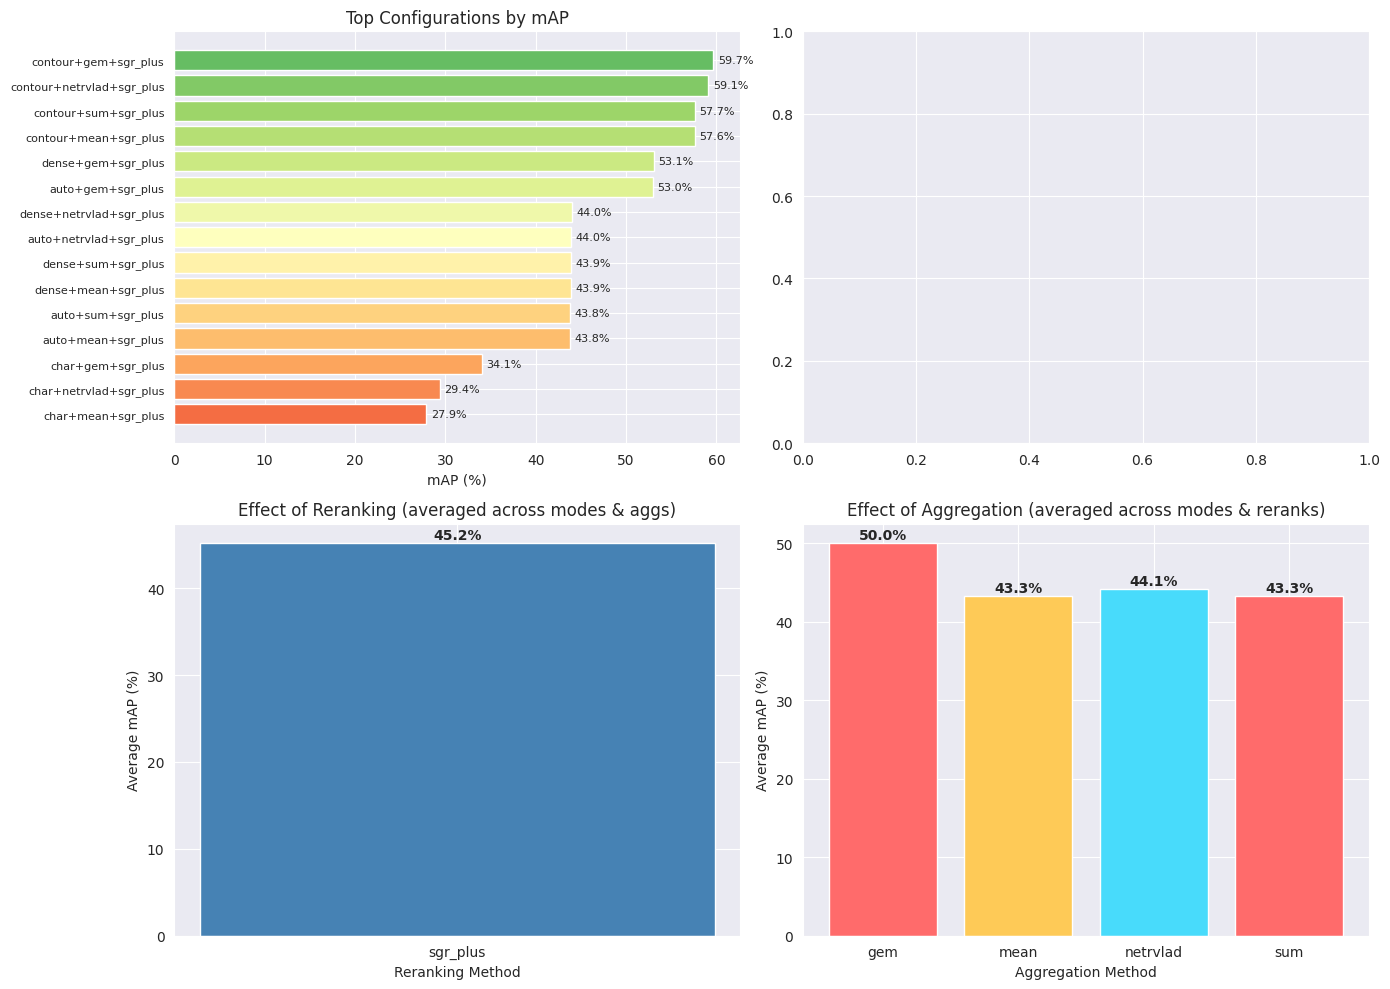

23:13:05 | INFO     | ℹ️  
🏆 BEST CONFIGURATION:
23:13:05 | INFO     | ℹ️     Mode: contour
23:13:05 | INFO     | ℹ️     Aggregation: gem
23:13:05 | INFO     | ℹ️     Reranking: sgr_plus
23:13:05 | INFO     | ℹ️     mAP: 59.67%


In [12]:
# ============================================================
# CELL 12: VISUALIZE ABLATION RESULTS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 6.5: ABLATION RESULTS VISUALIZATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'results_df' in dir() and len(results_df) > 0:
    # Display top results
    logger.info(Colors.MAGENTA + f'\n📊 TOP 10 CONFIGURATIONS:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌──────┬──────────┬───────┬──────────┬────────┬────────┬────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │ Rank │ Mode      │ Agg   │ Rerank   │  mAP   │ Top-1  │ Top-5  │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠──────┼──────────┼───────┼──────────┼────────┼────────┼────────┨' + Colors.RESET)
    for i, row in results_df.head(10).iterrows():
        rank = results_df.index.get_loc(i) + 1
        logger.info(Colors.YELLOW + f'   │  {rank:2d}  │ {row["mode"]:8s} │ {row["agg"]:5s} │ {row["rerank"]:8s} │ '
                                    f'{row["mAP"] * 100:6.2f}% │ {row["Top1"] * 100:6.2f}% │ {row["Top5"] * 100:6.2f}% │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └──────┴──────────┴───────┴──────────┴────────┴────────┴────────┘' + Colors.RESET)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Bar plot of top configurations
    ax1 = axes[0, 0]
    top_n = min(15, len(results_df))
    top_results = results_df.head(top_n)
    labels = [f'{r["mode"]}+{r["agg"]}+{r["rerank"]}' for _, r in top_results.iterrows()]
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))[::-1]
    ax1.barh(range(top_n), top_results['mAP'] * 100, color=colors)
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(labels, fontsize=8)
    ax1.set_xlabel('mAP (%)')
    ax1.set_title('Top Configurations by mAP')
    ax1.invert_yaxis()
    for i, v in enumerate(top_results['mAP']):
        ax1.text(v * 100 + 0.5, i, f'{v * 100:.1f}%', va='center', fontsize=8)

    # 2. Heatmap by mode and aggregation
    # ax2 = axes[0, 1]
    # pivot_data = results_df[results_df['rerank'] == 'none'].pivot(
    #     index='mode', columns='agg', values='mAP'
    # ) * 100
    # sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2,
    #             cbar_kws={'label': 'mAP (%)'})
    # ax2.set_title('mAP by Mode × Aggregation (no reranking)')

    # 3. Effect of reranking
    ax3 = axes[1, 0]
    rerank_effect = results_df.groupby('rerank')['mAP'].mean() * 100
    bars = ax3.bar(rerank_effect.index, rerank_effect.values,
                   color=['steelblue', 'coral', 'forestgreen'])
    ax3.set_xlabel('Reranking Method')
    ax3.set_ylabel('Average mAP (%)')
    ax3.set_title('Effect of Reranking (averaged across modes & aggs)')
    for bar, val in zip(bars, rerank_effect.values):
        ax3.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                 ha='center', fontweight='bold')

    # 4. Effect of aggregation
    ax4 = axes[1, 1]
    agg_effect = results_df.groupby('agg')['mAP'].mean() * 100
    bars = ax4.bar(agg_effect.index, agg_effect.values,
                   color=['#ff6b6b', '#feca57', '#48dbfb'])
    ax4.set_xlabel('Aggregation Method')
    ax4.set_ylabel('Average mAP (%)')
    ax4.set_title('Effect of Aggregation (averaged across modes & reranks)')
    for bar, val in zip(bars, agg_effect.values):
        ax4.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                 ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ablation_visualization.png', dpi=150)
    plt.show()

    # Best configuration
    best = results_df.iloc[0]
    logger.info(Colors.MAGENTA + f'\n🏆 BEST CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Mode: {best["mode"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Aggregation: {best["agg"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Reranking: {best["rerank"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No results to display. Run ablation study first.' + Colors.RESET)

## Step 7: PCA Whitening Analysis

Test the effect of PCA whitening on retrieval performance.

In [ ]:
# ============================================================
# CELL 13: PCA WHITENING ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔬 STEP 7: PCA WHITENING ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    # Load model
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    emb_dim = ckpt_data.get('args', {}).get('emb_dim', 64)

    model = create_resnet_patch_encoder(emb_dim=emb_dim)
    model.load_state_dict(ckpt_data['model_state'])
    model.eval()
    model = model.to(CVL_CONFIG['device'])

    cfg = RetrievalConfig(agg_type='gem', use_power_norm=True, power_alpha=0.4)

    # Extract train descriptors for PCA fitting
    logger.info(Colors.CYAN + '\n📊 Extracting TRAIN descriptors for PCA...' + Colors.RESET)
    train_labels, train_paths, train_descs = extract_descriptors(
        model=model, csv_path=str(CVL_TRAIN_CSV), root_dir=str(ROOT),
        cfg=cfg, device=CVL_CONFIG['device'], verbose=True
    )

    # Fit PCA with different component counts
    logger.info(Colors.CYAN + '\n🔧 Fitting PCA with different dimensions...' + Colors.RESET)
    pca_results = []

    for n_components in [None, 64, 32, 16]:
        comp_label = 'Full' if n_components is None else str(n_components)

        pca = fit_pca_whitening(train_descs, n_components=n_components, whiten=True, verbose=False)

        # Extract and transform test descriptors
        test_labels, test_paths, test_descs = extract_descriptors(
            model=model, csv_path=str(CVL_TEST_CSV), root_dir=str(ROOT),
            cfg=cfg, device=CVL_CONFIG['device'], verbose=False
        )

        test_descs_pca = apply_pca_whitening(test_descs, pca, verbose=False)
        mAP, metrics = mean_average_precision(test_labels, test_descs_pca, verbose=False)

        pca_results.append({
            'n_components': comp_label,
            'mAP': mAP,
            'Top1': metrics['Top1'],
            'dim': test_descs_pca.shape[1]
        })

        logger.info(
            Colors.YELLOW + f'   PCA-{comp_label:4s}: mAP={mAP * 100:.2f}%, dim={test_descs_pca.shape[1]}' + Colors.RESET)

    # Also test without PCA
    mAP_no_pca, metrics_no_pca = mean_average_precision(test_labels, test_descs, verbose=False)
    logger.info(Colors.YELLOW + f'   No PCA : mAP={mAP_no_pca * 100:.2f}%, dim={test_descs.shape[1]}' + Colors.RESET)

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    labels = ['No PCA'] + [r['n_components'] for r in pca_results]
    values = [mAP_no_pca * 100] + [r['mAP'] * 100 for r in pca_results]
    colors = ['gray'] + plt.cm.Blues(np.linspace(0.4, 0.8, len(pca_results))).tolist()

    bars = ax.bar(labels, values, color=colors, edgecolor='black')
    ax.set_ylabel('mAP (%)')
    ax.set_xlabel('PCA Components')
    ax.set_title('Effect of PCA Whitening on CVL')
    ax.axhline(mAP_no_pca * 100, color='red', linestyle='--', alpha=0.5, label='Baseline')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, val + 0.5, f'{val:.1f}%',
                ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'pca_analysis.png', dpi=150)
    plt.show()

    # Store best PCA descriptors for later use
    best_pca = max(pca_results, key=lambda x: x['mAP'])
    logger.info(Colors.MAGENTA + f'\n🏆 BEST PCA CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Components: {best_pca["n_components"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   mAP: {best_pca["mAP"] * 100:.2f}%' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)

## Step 8: SGR Reranking Parameter Tuning

Find optimal SGR parameters (k, gamma, iterations).

In [ ]:
# ============================================================
# CELL 14: SGR RERANKING PARAMETER TUNING
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔀 STEP 8: SGR RERANKING PARAMETER TUNING' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'test_descs_pca' in dir() or 'test_descs' in dir():
    # Use PCA-whitened descriptors if available
    base_descs = test_descs_pca if 'test_descs_pca' in dir() else test_descs

    logger.info(Colors.CYAN + f'\n📊 Base descriptors shape: {base_descs.shape}' + Colors.RESET)

    # Baseline (no reranking)
    mAP_baseline, metrics_baseline = mean_average_precision(test_labels, base_descs, verbose=False)
    logger.info(Colors.MAGENTA + f'\n📊 BASELINE (No Reranking):' + Colors.RESET)

    # Test different SGR configurations
    sgr_configs = [
        # (k, gamma, iterations)
        (2, 0.2, 2),
        (2, 0.4, 2),
        (2, 0.6, 2),
        (3, 0.3, 2),
        (3, 0.4, 2),
        (3, 0.5, 2),
        (5, 0.3, 2),
        (5, 0.4, 2),
        (5, 0.5, 2),
        (2, 0.4, 3),
        (3, 0.4, 3),
        (5, 0.4, 3),
    ]

    # logger.info(Colors.CYAN + f'\n🔬 Testing {len(sgr_configs)} SGR configurations...' + Colors.RESET)
    # sgr_results = []

    for k, gamma, iters in tqdm(sgr_configs, desc='SGR configs'):
        descs_sgr = apply_sgr(base_descs, k=k, gamma=gamma, num_iterations=iters, verbose=False)
        mAP, metrics = mean_average_precision(test_labels, descs_sgr, verbose=False)

        sgr_results.append({
            'k': k,
            'gamma': gamma,
            'iterations': iters,
            'mAP': mAP,
            'Top1': metrics['Top1'],
            'improvement': mAP - mAP_baseline
        })

    # Sort by mAP
    sgr_results = sorted(sgr_results, key=lambda x: x['mAP'], reverse=True)

    # Display results
    logger.info(Colors.MAGENTA + f'\n📊 SGR RERANKING RESULTS:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌─────┬───────┬──────┬────────┬────────┬─────────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │  k  │ gamma │ iter │  mAP   │ Top-1  │   Δ mAP     │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠─────┼───────┼──────┼────────┼────────┼─────────────┨' + Colors.RESET)
    logger.info(
        Colors.YELLOW + f'   │  -  │   -   │  -   │ {mAP_baseline * 100:6.2f}% │ {metrics_baseline["Top1"] * 100:6.2f}% │ baseline     │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠─────┼───────┼──────┼────────┼────────┼─────────────┨' + Colors.RESET)
    for r in sgr_results[:10]:
        delta = r['improvement'] * 100
        sign = '+' if delta >= 0 else ''
        marker = ' 🏆' if r == sgr_results[0] else ''
        logger.info(
            Colors.YELLOW + f'   │ {r["k"]:3d} │ {r["gamma"]:.1f}  │  {r["iterations"]}  │ {r["mAP"] * 100:6.2f}% │ {r["Top1"] * 100:6.2f}% │ {sign}{delta:5.2f}%{marker} │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └─────┴───────┴──────┴────────┴────────┴─────────────┘' + Colors.RESET)

    # Best configuration
    best_sgr = sgr_results[0]
    logger.info(Colors.MAGENTA + f'\n🏆 BEST SGR CONFIGURATION:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   k: {best_sgr["k"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   gamma: {best_sgr["gamma"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   iterations: {best_sgr["iterations"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   mAP: {best_sgr["mAP"] * 100:.2f}%' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Improvement over baseline: {best_sgr["improvement"] * 100:.2f}%' + Colors.RESET)
    # Apply best SGR
    descs_best_sgr = apply_sgr(base_descs, k=best_sgr['k'], gamma=best_sgr['gamma'],
                               num_iterations=best_sgr['iterations'], verbose=False)
else:
    logger.error(Colors.RED + '❌ No descriptors available. Run evaluation first.' + Colors.RESET)

## Step 9: Per-Bin Analysis

Analyze performance by text quantity bins.

In [ ]:
# ============================================================
# CELL 15: PER-BIN ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n📊 STEP 9: PER-BIN ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt and 'descs' in dir():
    # Save descriptors for ranking
    np.save(RESULTS_DIR / 'cvl_descs.npy', descs)

    # Generate ranks
    logger.info(Colors.CYAN + '\n🔄 Computing ranking for all queries...' + Colors.RESET)
    make_ranks(
        descs_path=str(RESULTS_DIR / 'cvl_descs.npy'),
        csv_path=str(CVL_TEST_CSV),
        out_path=str(RESULTS_DIR / 'cvl_ranks.json')
    )

    # Per-bin metrics
    per_bin_args = [
        '--ranks', str(RESULTS_DIR / 'cvl_ranks.json'),
        '--labels', str(CVL_LABELS_JSON),
        '--text-quantity', str(CVL_TEXT_QTY_JSON),
        '--out-csv', str(RESULTS_DIR / 'cvl_per_bin_metrics.csv')
    ]
    sys.argv = ['per_bin_csv.py'] + per_bin_args
    per_bin_csv()

    # Load and analyze results
    bin_df = pd.read_csv(RESULTS_DIR / 'cvl_per_bin_metrics.csv')
    bin_stats = bin_df.groupby('bin')['ap_full'].agg(['mean', 'std', 'count'])

    logger.info(Colors.MAGENTA + f'\n📊 mAP by Text Quantity Bin:' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┌──────────────┬────────┬────────┬────────┐' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   │     Bin      │  mAP   │  Std   │ Count  │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   ┠──────────────┼────────┼────────┼────────┨' + Colors.RESET)
    for bin_name, row in bin_stats.iterrows():
        logger.info(
            Colors.YELLOW + f'   │ {bin_name:<12} │ {row["mean"] * 100:6.2f}% │ {row["std"] * 100:6.2f}% │ {int(row["count"]):6d} │' + Colors.RESET)
    logger.info(Colors.YELLOW + f'   └──────────────┴────────┴────────┴────────┘' + Colors.RESET)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar plot of mAP by bin
    ax1 = axes[0]
    bins = bin_stats.index.tolist()
    means = bin_stats['mean'].values * 100
    stds = bin_stats['std'].values * 100

    bars = ax1.bar(range(len(bins)), means, yerr=stds, capsize=5,
                   color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'][:len(bins)],
                   edgecolor='black')
    ax1.set_xticks(range(len(bins)))
    ax1.set_xticklabels(bins, rotation=45, ha='right')
    ax1.set_ylabel('mAP (%)')
    ax1.set_title('mAP by Text Quantity Bin')
    ax1.axhline(bin_df['ap_full'].mean() * 100, color='red', linestyle='--',
                label=f'Overall: {bin_df["ap_full"].mean() * 100:.1f}%')
    ax1.legend()

    # Sample count per bin
    ax2 = axes[1]
    counts = bin_stats['count'].values
    ax2.bar(range(len(bins)), counts, color='steelblue', edgecolor='black')
    ax2.set_xticks(range(len(bins)))
    ax2.set_xticklabels(bins, rotation=45, ha='right')
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Sample Distribution by Bin')
    for i, c in enumerate(counts):
        ax2.text(i, c + 5, str(int(c)), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'per_bin_analysis.png', dpi=150)
    plt.show()
else:
    logger.error(Colors.RED + '❌ No checkpoint or descriptors available. Run evaluation first.' + Colors.RESET)

## Step 10: Final Summary

Complete summary of all experiments and best configurations.

In [ ]:
# ============================================================
# CELL 16: FINAL SUMMARY
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🎉 CVL WRITER RETRIEVAL - FINAL SUMMARY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

logger.info(Colors.CYAN + f'\n📊 DATASET:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Train: {n_train} pages from {len(train_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Test: {n_test} pages from {len(test_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   Protocol: Writer-disjoint (correct!)' + Colors.RESET)

logger.info(Colors.CYAN + f'\n⚙️  TRAINING CONFIG:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Backbone: {CVL_CONFIG["backbone"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Pretrained: {CVL_CONFIG["pretrained"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Embedding dim: {CVL_CONFIG["emb_dim"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Epochs: {CVL_CONFIG["epochs"]}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Margin: {CVL_CONFIG["margin"]}' + Colors.RESET)

logger.info(Colors.CYAN + f'\n📈 RESULTS SUMMARY:' + Colors.RESET)

# Baseline
if 'baseline_mAP' in dir():
    logger.info(Colors.CYAN + f'   Baseline' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {baseline_mAP * 100:.2f}%' + Colors.RESET)
# Best ablation
if 'results_df' in dir() and len(results_df) > 0:
    best = results_df.iloc[0]
    logger.info(Colors.CYAN + f'   Best Ablation ({best["mode"]}+{best["agg"]}+{best["rerank"]})' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)

# Best PCA
if 'best_pca' in dir():
    logger.info(Colors.CYAN + f'   Best PCA ({best_pca["n_components"]} components)' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best_pca["mAP"] * 100:.2f}%' + Colors.RESET)

# Best SGR
if 'best_sgr' in dir():
    logger.info(
        Colors.CYAN + f'   Best SGR (k={best_sgr["k"]}, γ={best_sgr["gamma"]}, iter={best_sgr["iterations"]})' + Colors.RESET)
    logger.info(Colors.CYAN + f'   └── mAP: {best_sgr["mAP"] * 100:.2f}%' + Colors.RESET)

logger.info(Colors.CYAN + f'\n💾 SAVED FILES:' + Colors.RESET)
logger.info(Colors.CYAN + f'   Checkpoints: {CHECKPOINT_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Results: {RESULTS_DIR}' + Colors.RESET)

logger.info(Colors.BOLD_GREEN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_GREEN + '\n✅ CVL PIPELINE COMPLETE!' + Colors.RESET)
logger.info(Colors.BOLD_GREEN + '=' * 70 + Colors.RESET)